In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install wfdb==3.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.1 MB/s eta 0:00:00


In [88]:
from math import e
import wfdb
import numpy as np

# List of records
records = ['100', '101', '109', '118', '217']

# Initialize empty lists to store combined data
combined_signals = []
combined_r_peaks = []
combined_labels = []
fs = None  # Sampling frequency
total_samples = 0  # To keep track of the total number of samples processed

# List of labels to remove
labels_to_remove = ['/', '+', '~', 'x', '|', 'Q', 'F', 'f', 'x','A']

# Loop through all records and combine their data
for record in records:
    # Load the signal and annotations for the current record
    signals, fields = wfdb.rdsamp(record, pn_dir='mitdb')
    annotation = wfdb.rdann(record, 'atr', pn_dir='mitdb')

    # Append the signals from the current record to the combined_signals list
    combined_signals.append(signals)

    # Adjust the R-peak locations by adding total_samples (shift for new record)
    adjusted_r_peaks = annotation.sample + total_samples
    combined_r_peaks.extend(adjusted_r_peaks)  # Add adjusted R-peaks to the combined list

    # Add labels (normal/abnormal beats) for the current record
    combined_labels.extend(annotation.symbol)

    # Update the total number of samples processed so far
    total_samples += signals.shape[0]

    # Store sampling frequency (assuming all records have the same sampling frequency)
    if fs is None:
        fs = fields['fs']

# Concatenate all signals into a single NumPy array
combined_signals = np.concatenate(combined_signals, axis=0)

# Create Time Axis for the combined signals
time = np.arange(len(combined_signals)) / fs

# Accessing the first channel of the combined ECG signal
ecg_signal = combined_signals[:, 0]

# Remove unwanted labels
filtered_r_peaks = []
filtered_labels = []

for r_peak, label in zip(combined_r_peaks, combined_labels):
    if label not in labels_to_remove:
        filtered_r_peaks.append(r_peak)
        filtered_labels.append(label)


# print first 10 R-peaks and their corresponding filtered labels:
print("First 10 R-peaks:", filtered_r_peaks[:10])
print("First 10 Filtered Labels:", filtered_labels[:10])


First 10 R-peaks: [77, 370, 662, 946, 1231, 1515, 1809, 2402, 2706, 2998]
First 10 Filtered Labels: ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [89]:
# signals is a NumPy array, you can directly access its shape
num_rows, num_columns = combined_signals.shape

# Print the result
print(f"Number of rows (samples): {num_rows}")
print(f"Number of columns (channels): {num_columns}")


Number of rows (samples): 3250000
Number of columns (channels): 2


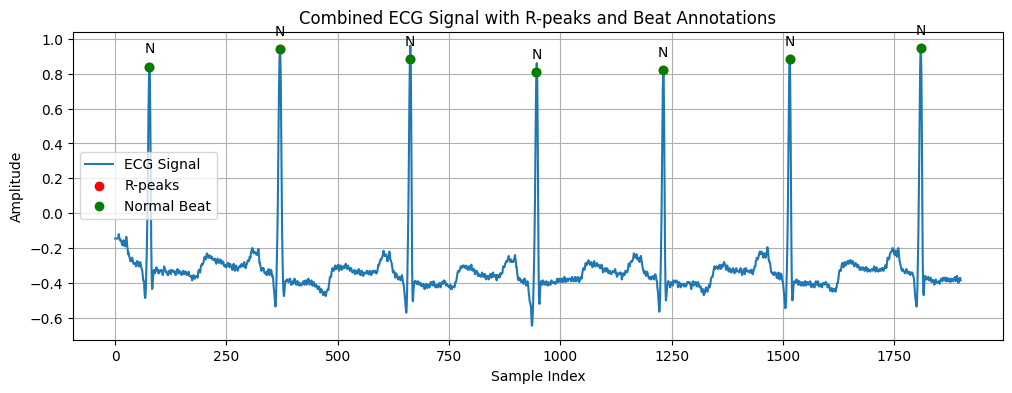

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# First, we ensure to use the first channel of the combined signals
ecg_signal = combined_signals[:, 0]

# Plot a portion of the combined ECG signal
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal[:1900], label='ECG Signal')  # Plot first 1900 samples of the first channel

# Highlight the R-peaks that are within the plotting range
valid_r_peaks = np.array(filtered_r_peaks)[np.array(filtered_r_peaks) < 1900]
plt.scatter(valid_r_peaks, ecg_signal[valid_r_peaks], color='red', label='R-peaks')

# Annotate normal and abnormal beats
for i, (sample, symbol) in enumerate(zip(filtered_r_peaks, filtered_labels)):
    if sample < 1900:  # Ensure we are within the plotted range
        if symbol == 'N':  # Normal beat
            plt.plot(sample, ecg_signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample, ecg_signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample, ecg_signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample, ecg_signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

# Final plot adjustments
plt.title('Combined ECG Signal with R-peaks and Beat Annotations')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


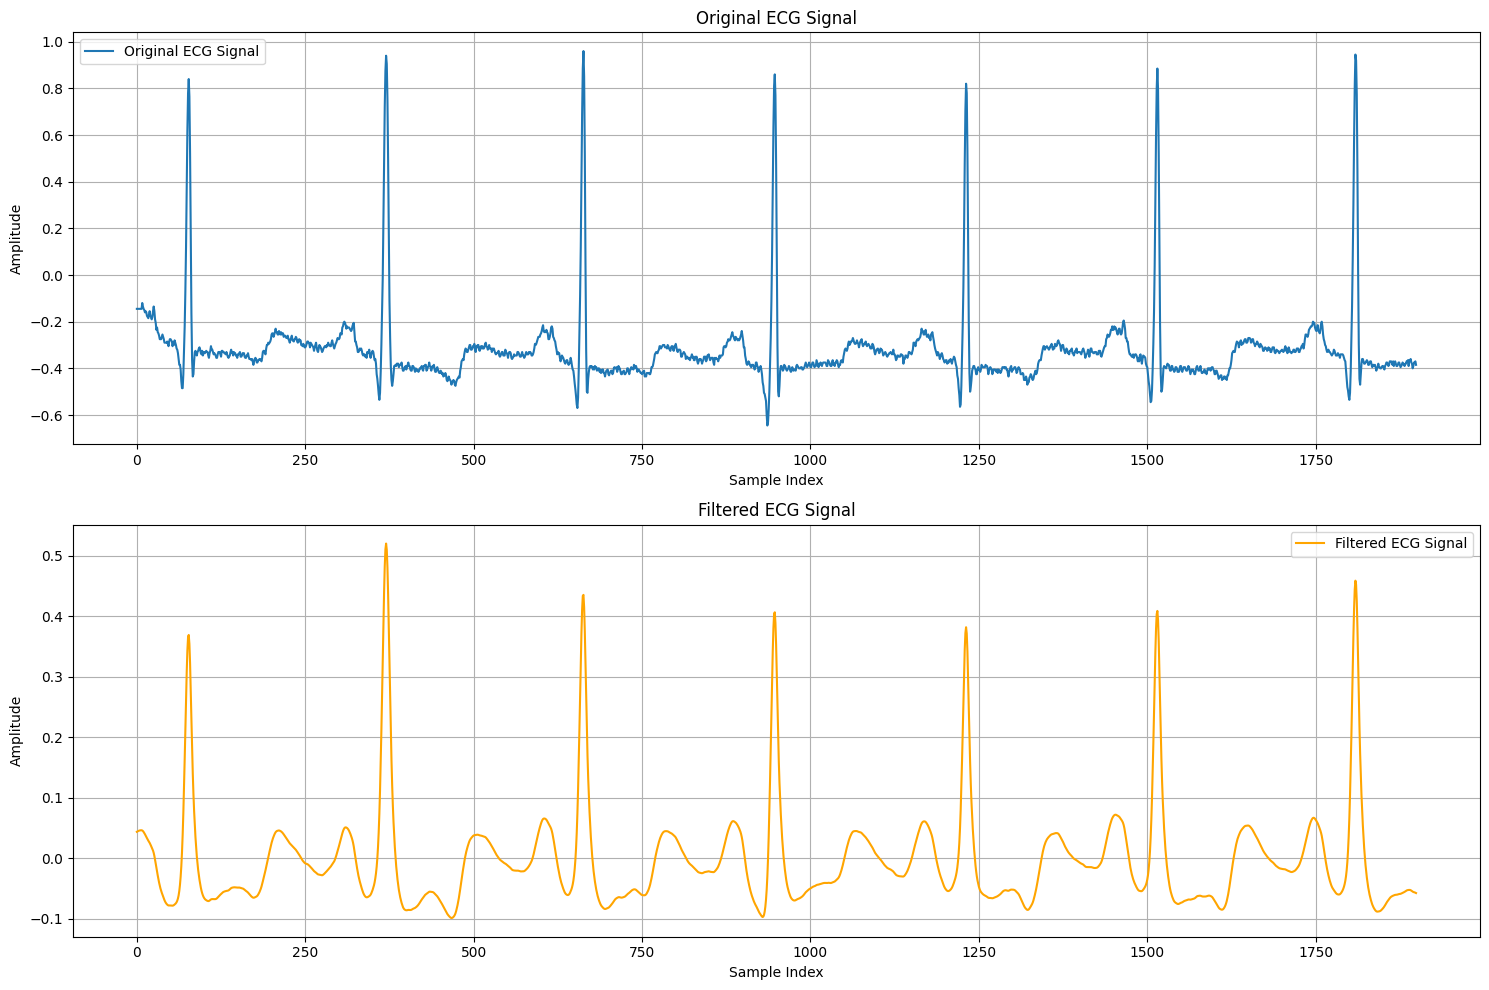

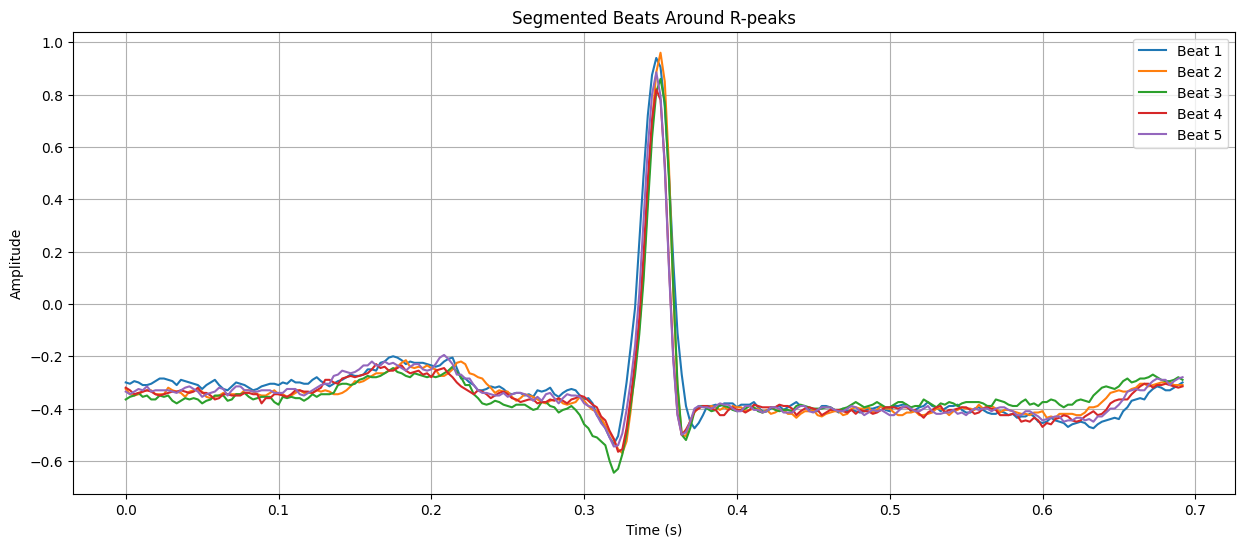

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import wfdb

# Function to apply a bandpass filter to the ECG signal
def bandpass_filter(ecg_signal, fs):
    lowcut = 1.0
    highcut = 10.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    return filtfilt(b, a, ecg_signal)


# Check if the combined signal has enough samples
if len(ecg_signal) < 10:
    raise ValueError("The combined ECG signal is too short for filtering.")

# Apply bandpass filter to the first channel of combined signals
filtered_signal = bandpass_filter(ecg_signal, fs)

# Segment the signal around each R-peak (0.35s before and after)
window_before = int(0.35 * fs)
window_after = int(0.35 * fs)

# Initialize an array to store the segmented beats
segmented_beats = []

for r_peak in filtered_r_peaks:
    if r_peak - window_before >= 0 and r_peak + window_after < len(ecg_signal):
        beat_segment = ecg_signal[r_peak - window_before:r_peak + window_after]
        segmented_beats.append(beat_segment)

# Plot original and filtered ECG signals
plt.figure(figsize=(15, 10))

# Original ECG signal
plt.subplot(2, 1, 1)
plt.plot(ecg_signal[:1900], label='Original ECG Signal')
plt.title('Original ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.grid(True)

# Filtered ECG signal
plt.subplot(2, 1, 2)
plt.plot(filtered_signal[:1900], label='Filtered ECG Signal', color='orange')
plt.title('Filtered ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot segmented beats
plt.figure(figsize=(15, 6))
for i, beat in enumerate(segmented_beats[:5]):  # Plot the first 5 segments
    plt.plot(np.arange(len(beat)) / fs, beat, label=f'Beat {i+1}')
plt.title('Segmented Beats Around R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


Unique arrhythmia labels: {'V', 'R', 'L', 'N'}

Counts of each arrhythmia type:
N: 4343
L: 2492
R: 2166
V: 217


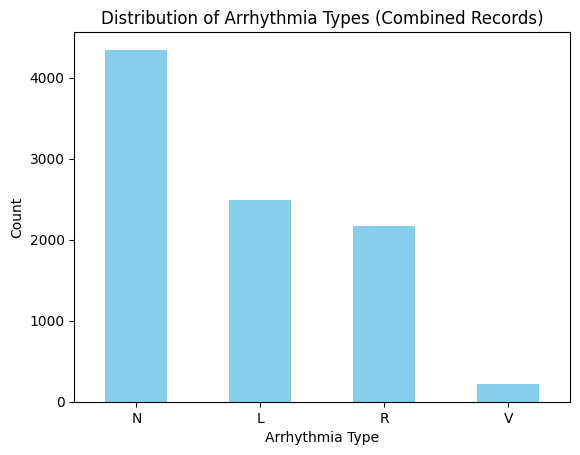

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

#  Get unique labels from the combined labels
unique_labels = set(filtered_labels)
print("Unique arrhythmia labels:", unique_labels)

#  Display the counts of each arrhythmia type
label_counts = pd.Series(filtered_labels).value_counts()
print("\nCounts of each arrhythmia type:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

#  Plot the distribution of arrhythmia types
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Arrhythmia Types (Combined Records)')
plt.xlabel('Arrhythmia Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [93]:
!pip install PyWavelets==1.4.1

Number of Wavelet Coefficients: 9217


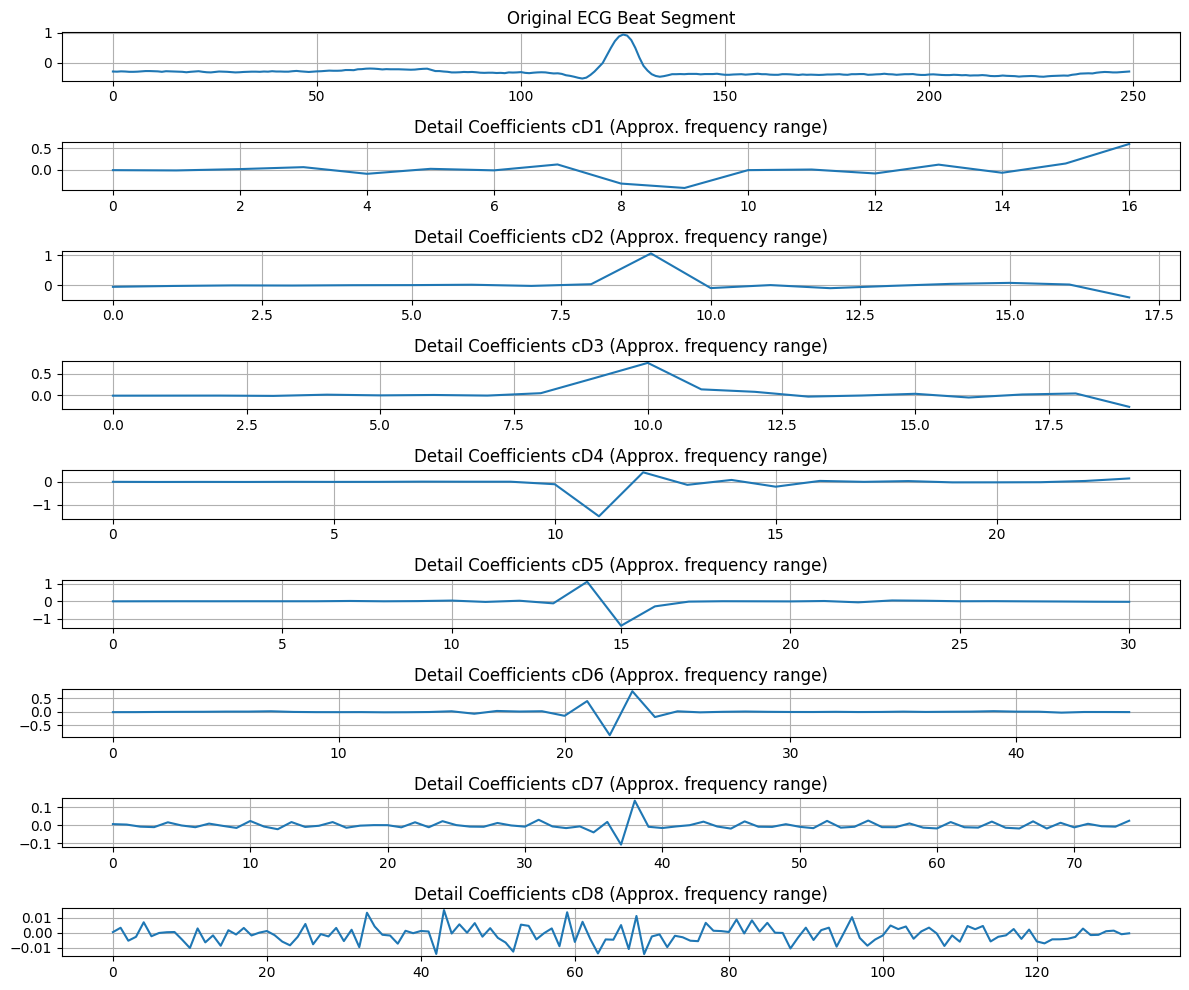

In [94]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def wavelet_decomposition(beats, wavelet='bior6.8', level=8):
    wavelet_coeffs = []
    for beat in beats:
        coeffs = pywt.wavedec(beat, wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs  # Return as a list

# Ensure combined_segmented_beats is defined and populated
if 'segmented_beats' in locals() and len(segmented_beats) > 0:
    # Pad segments to the length of the longest beat
    max_length = max(len(beat) for beat in segmented_beats)
    padded_beats = [np.pad(beat, (0, max_length - len(beat)), mode='constant') for beat in segmented_beats]

    # Apply wavelet decomposition to the padded segmented beats
    wavelet_coeffs = wavelet_decomposition(padded_beats)

    # Print the shape of the wavelet coefficients for inspection
    print(f'Number of Wavelet Coefficients: {len(wavelet_coeffs)}')

    # Keep only the detail coefficients (cD1 to cD8) and ignore cA8
    detail_coeffs = []
    for coeffs in wavelet_coeffs:
        cD = coeffs[1:]  # Keep detail coefficients (cD1 to cD8)
        detail_coeffs.append(cD)

    # Example of wavelet decomposition visualization for the first combined segment
    if len(detail_coeffs) > 0:
        coeffs = wavelet_coeffs[0]
        details = coeffs[1:]  # Details (cD1 to cD8)

        # Visualize the original segment and the decomposed components
        plt.figure(figsize=(12, 10))

        # Display the original beat segment
        plt.subplot(len(details) + 1, 1, 1)
        plt.plot(segmented_beats[0], label='Original Beat Segment')
        plt.title('Original ECG Beat Segment')
        plt.grid()

        # Display the detail coefficients (cD1 to cD8)
        for i, detail in enumerate(details, start=1):
            plt.subplot(len(details) + 1, 1, i + 1)
            plt.plot(detail, label=f'Detail Coefficients cD{i}')
            plt.title(f'Detail Coefficients cD{i} (Approx. frequency range)')
            plt.grid()

        plt.tight_layout()
        plt.show()
    else:
        print("No detail coefficients found.")
else:
    print("No segmented beats found. Please ensure 'segmented_beats' is defined.")


Shape of flattened coefficients: (9217, 347)
Explained variance by each principal component: [0.54734086 0.29040152 0.05346239 0.02578544]
Total explained variance: 0.9169902105950947


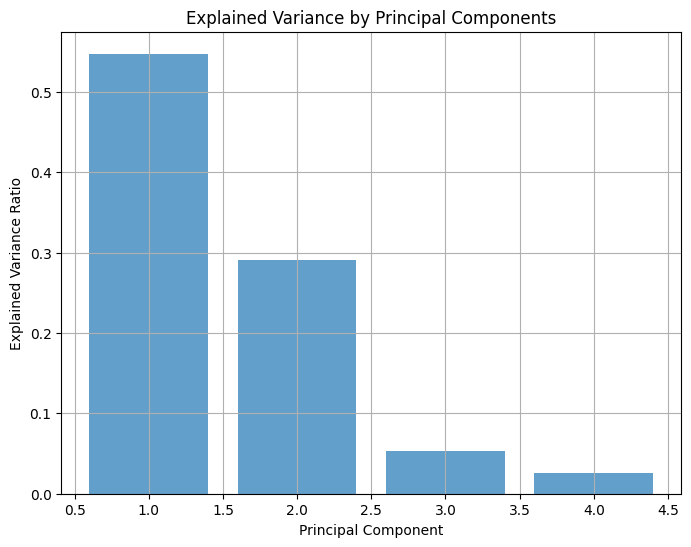

In [95]:
from sklearn.decomposition import PCA

#  PCA Dimensionality Reduction
def apply_pca(wavelet_coefficients, n_components=4):
    # Flatten the wavelet coefficients for PCA input
    flattened_coeffs = []
    for coeff in wavelet_coefficients:
        # Concatenate detail coefficients (cD1 to cD8) only
        flattened_coeff = np.concatenate(coeff[1:])  # Skip the approximation coefficients (cA8)
        flattened_coeffs.append(flattened_coeff)

    flattened_coeffs = np.array(flattened_coeffs)  # Convert to a NumPy array
    print(f"Shape of flattened coefficients: {flattened_coeffs.shape}")

    # Apply PCA to reduce dimensions to 'n_components'
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(flattened_coeffs)

    return principal_components, pca

# Apply PCA on the wavelet coefficients obtained from Step 2
principal_components, pca_model = apply_pca(detail_coeffs)

# Explained variance ratios (to show how much information is preserved)
explained_variance = pca_model.explained_variance_ratio_
print(f"Explained variance by each principal component: {explained_variance}")
print(f"Total explained variance: {np.sum(explained_variance)}")

# Plot the explained variance ratios for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()


In [96]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that the size of labels corresponds to the size of the features (principal_components)
if len(principal_components) > len(filtered_labels):
    principal_components = principal_components[:len(filtered_labels)]
elif len(principal_components) < len(filtered_labels):
    filtered_labels = filtered_labels[:len(principal_components)]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(principal_components, filtered_labels, test_size=0.2, random_state=42)


In [97]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
#  Classification with SVM
svm = SVC(kernel='linear')  # Use RBF (Radial Basis Function) kernel
svm.fit(X_train, y_train)  # Train the SVM classifier

# Predict labels on the test set
y_pred_svm = svm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_svm)
SEN = recall_score(y_test, y_pred_svm, average='macro')  # Sensitivity (macro average)
SPE = precision_score(y_test, y_pred_svm, average='macro')  # Specificity (macro average)

# Print the results
print(f"Accuracy: {accuracy :.2f}")
print(f"Sensitivity (SEN): {SEN:.2f}")
print(f"Specificity (SPE): {SPE:.2f}")

Classification Report:
              precision    recall  f1-score   support

           L       0.98      1.00      0.99       524
           N       0.98      0.99      0.99       851
           R       0.99      0.99      0.99       431
           V       0.63      0.45      0.52        38

    accuracy                           0.98      1844
   macro avg       0.90      0.86      0.87      1844
weighted avg       0.98      0.98      0.98      1844

Accuracy: 0.98
Sensitivity (SEN): 0.86
Specificity (SPE): 0.90


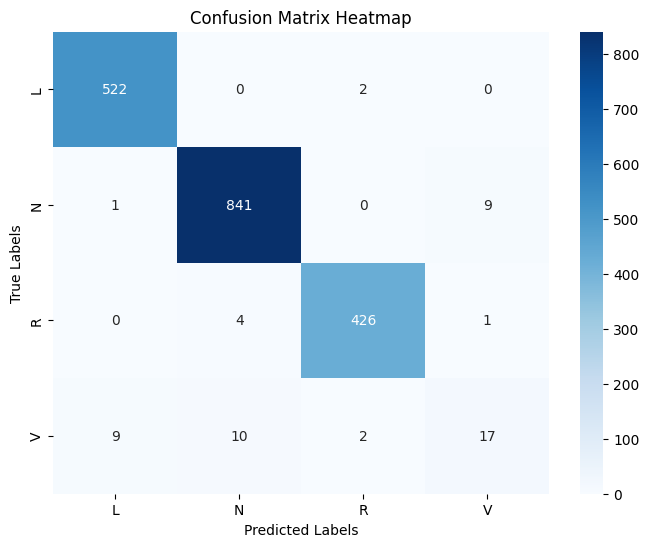

In [98]:
#  Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

#  Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(filtered_labels),
            yticklabels=np.unique(filtered_labels))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [99]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
# Classification with SVM
svm = SVC(kernel='rbf', decision_function_shape='ovo')  # Use RBF (Radial Basis Function) kernel
svm.fit(X_train, y_train)  # Train the SVM classifier

# Predict labels on the test set
y_pred_svm = svm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_svm)
SEN = recall_score(y_test, y_pred_svm, average='macro')  # Sensitivity (macro average)
SPE = precision_score(y_test, y_pred_svm, average='macro')  # Specificity (macro average)

# Print the results
print(f"Accuracy: {accuracy :.2f}")
print(f"Sensitivity (SEN): {SEN:.2f}")
print(f"Specificity (SPE): {SPE:.2f}")

Classification Report:
              precision    recall  f1-score   support

           L       0.98      1.00      0.99       524
           N       0.98      0.99      0.99       851
           R       0.99      0.99      0.99       431
           V       0.67      0.42      0.52        38

    accuracy                           0.98      1844
   macro avg       0.91      0.85      0.87      1844
weighted avg       0.98      0.98      0.98      1844

Accuracy: 0.98
Sensitivity (SEN): 0.85
Specificity (SPE): 0.91


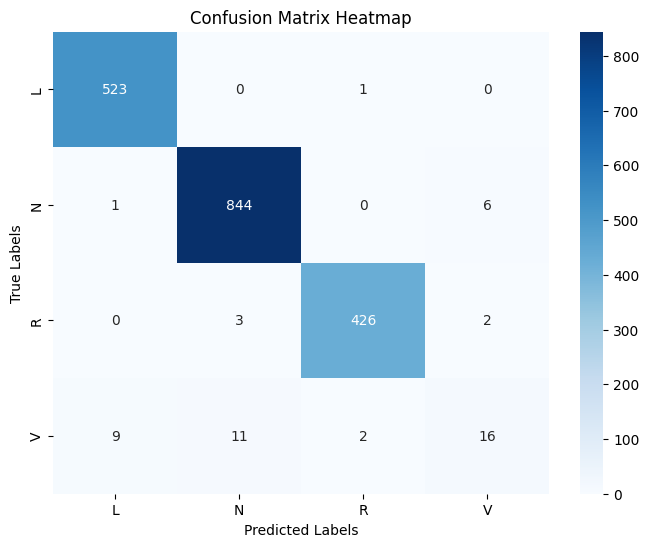

In [100]:
#  Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(filtered_labels),
            yticklabels=np.unique(filtered_labels))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [101]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
#  Classification with SVM
svm = SVC(kernel='sigmoid')  # Use RBF (Radial Basis Function) kernel
svm.fit(X_train, y_train)  # Train the SVM classifier

# Predict labels on the test set
y_pred_svm = svm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_svm)
SEN = recall_score(y_test, y_pred_svm, average='macro')  # Sensitivity (macro average)
SPE = precision_score(y_test, y_pred_svm, average='macro')  # Specificity (macro average)

# Print the results
print(f"Accuracy: {accuracy :.2f}")
print(f"Sensitivity (SEN): {SEN:.2f}")
print(f"Specificity (SPE): {SPE:.2f}")

Classification Report:
              precision    recall  f1-score   support

           L       0.92      0.96      0.94       524
           N       0.97      0.98      0.97       851
           R       0.98      0.98      0.98       431
           V       0.00      0.00      0.00        38

    accuracy                           0.96      1844
   macro avg       0.72      0.73      0.72      1844
weighted avg       0.94      0.96      0.95      1844

Accuracy: 0.96
Sensitivity (SEN): 0.73
Specificity (SPE): 0.72


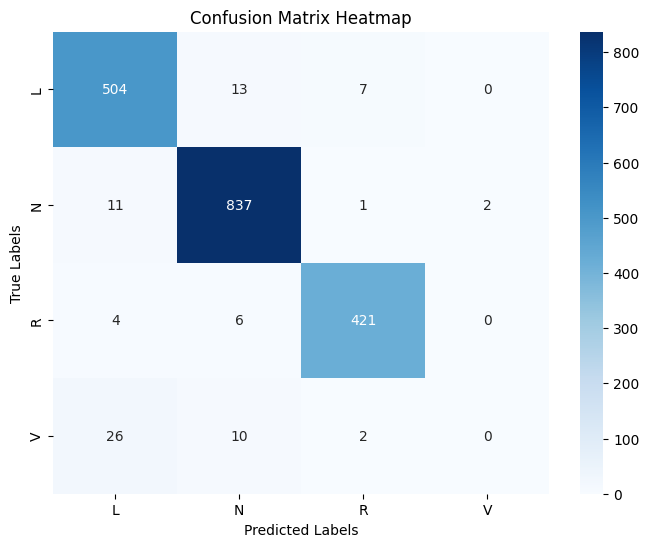

In [102]:
#  Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(filtered_labels),
            yticklabels=np.unique(filtered_labels))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [103]:
from sklearn.neighbors import KNeighborsClassifier
# Classifier 1: KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluate the KNN Model
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Evaluation


ACC = accuracy_score(y_test, y_pred_knn)
SEN = recall_score(y_test, y_pred_knn, average='macro')  # Sensitivity (macro average)
SPE = precision_score(y_test, y_pred_knn, average='macro')  # Specificity (macro average)

# Print the results
print(f"Sensitivity (SEN): {SEN:.2f}")
print(f"Specificity (SPE): {SPE:.2f}")
print(f"Accuracy (ACC): {ACC:.2f}")

KNN Classification Report:
              precision    recall  f1-score   support

           L       0.98      1.00      0.99       524
           N       0.98      0.99      0.98       851
           R       0.99      0.99      0.99       431
           V       0.55      0.29      0.38        38

    accuracy                           0.98      1844
   macro avg       0.88      0.82      0.84      1844
weighted avg       0.97      0.98      0.97      1844

Sensitivity (SEN): 0.82
Specificity (SPE): 0.88
Accuracy (ACC): 0.98


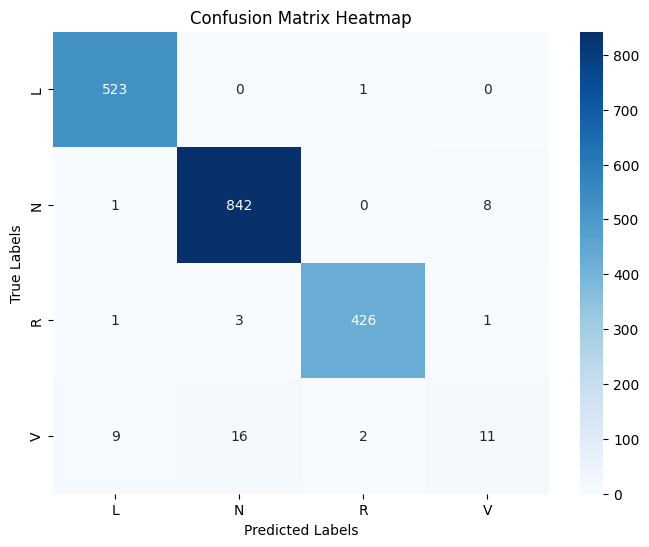

In [104]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(filtered_labels),
            yticklabels=np.unique(filtered_labels))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

KNN Classification Report:
              precision    recall  f1-score   support

           L       0.98      1.00      0.99       524
           N       0.98      0.99      0.98       851
           R       0.99      0.99      0.99       431
           V       0.55      0.29      0.38        38

    accuracy                           0.98      1844
   macro avg       0.88      0.82      0.84      1844
weighted avg       0.97      0.98      0.97      1844

Sensitivity (SEN): 0.85
Specificity (SPE): 0.91
Accuracy: 0.9793926247288504 at K = 30


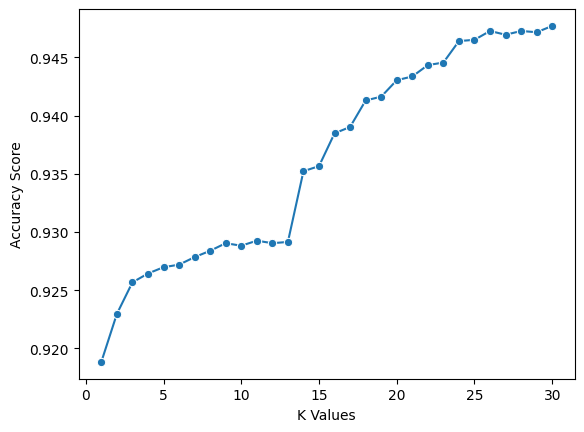

In [105]:
from sklearn import metrics
# using cross validation
from sklearn.model_selection import cross_val_score
import seaborn as sns


k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, principal_components, filtered_labels, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Evaluate the KNN Model
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

#Evaluation
y_pred_knn = knn.predict(X_test)
SEN = recall_score(y_test, y_pred_knn, average='macro')  # Sensitivity (macro average)
SPE = precision_score(y_test, y_pred_knn, average='macro')  # Specificity (macro average)

# Print the results
print(f"Sensitivity (SEN): {SEN:.2f}")
print(f"Specificity (SPE): {SPE:.2f}")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_knn),"at K =",best_k)

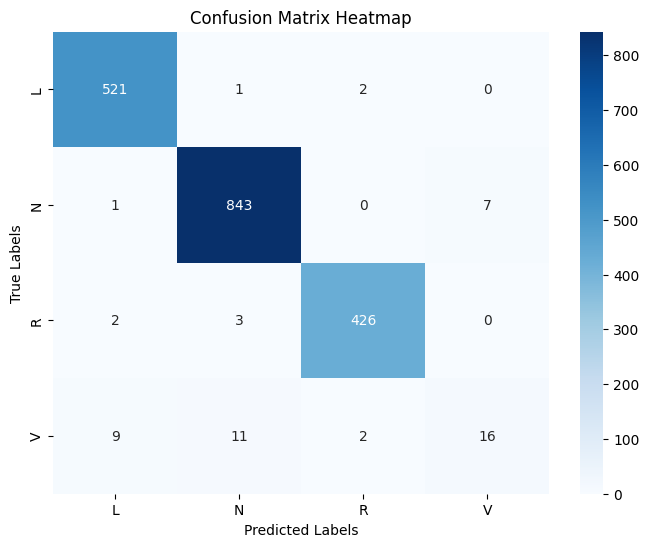

In [106]:
#  Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

#  Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(filtered_labels),
            yticklabels=np.unique(filtered_labels))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()